# 2D Ising Model

## Boltzmann Distribution

In [1]:
using GLMakie
using CairoMakie
using OffsetArrays
using Random
using ProgressMeter
using Statistics

As we argued with our hard disk calculations,  a sufficiently chaotic system will  uniformly sample all available states.  We will *define* this to be the equilibrium ensemble.  Consequently, instead of running dynamics, we can just sample from this same distribution.

One small caveat is that we want to think about a system coupled to a heat bath:

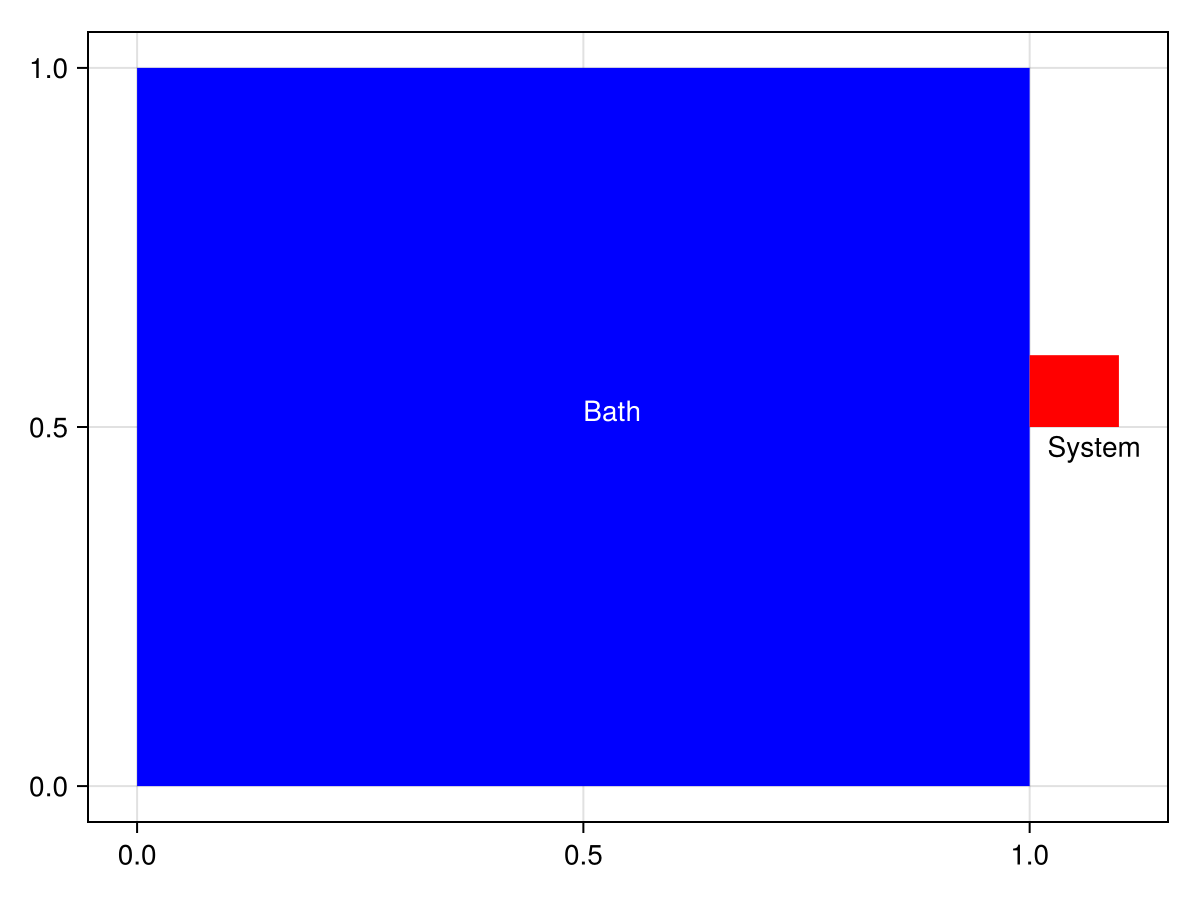

CairoMakie.Screen{IMAGE}


In [2]:
#CairoMakie.activate!(type = "svg")
CairoMakie.activate!(type = "png")
fig = Figure()
ax=Axis(fig[1,1])
poly!(ax,Rect(0,0,1,1),color=:blue)
poly!(ax,Rect(1,0.5,0.1,0.1),color=:red)
text!(ax,0.5,0.5,text="Bath",color=:white)
text!(ax,1.02,0.45,text="System")
display(fig)

When the bath and system are in *equilibrium*, the allowed states of the combined System+Bath are all equally likely.  If energy can go between the two, then the probability of a *given* system state $x$ with energy $\epsilon_x$ is
\begin{equation}
p(x)\propto \Omega_{\rm bath}(E-\epsilon_x)
\end{equation}
where $\Omega_{\rm bath}(E)$ is the number of bath states of energy $E$.

As we did with kinetic theory, we write
\begin{equation}
\Omega_{\rm bath}(E)=e^{S_{\rm bath}(E)/k_B}
\end{equation}
which defines the entropy.  We then Taylor expand,
\begin{align}
p(x)&\propto \Omega_{\rm bath}(E-\epsilon_x)\\
&= \exp\left(\frac{S_{\rm bath}(E-\epsilon_x)}{k_B}\right)\\
&\approx \exp\left(\frac{S_{\rm bath}(E)}{k_B} - \frac{1}{k_B} \frac{\partial S_{\rm bath}}{\partial E} \epsilon_x\right)\\
&\propto \exp\left(-\frac{1}{k_B T_{\rm bath}} \epsilon\right).
\end{align}
where
\begin{equation}
\frac{1}{T_{\rm bath}}= \frac{\partial S_{\rm bath}}{\partial E}.
\end{equation}
For notational simplicity we often write
\begin{equation}
\beta=\frac{1}{k_B T}.
\end{equation}
Thus the equilibrium probability distribution for a system in contact with a heat bath is
\begin{equation}
p(x)\propto e^{-\beta \epsilon_x}.
\end{equation}
If we can sample from this distribution, then we can calculate properties of the equilibrium ensemble.  We will use a Markov Chain Monte Carlo approach to do this sampling.

## Magnetic Models

As a concrete example, we will think about a simple model for a magnet, the Ising model.  We are going to think of our magnet as made up of a square array of spins.  Each spin can point in one of two directions.  The state of the system will then be specified by an array of binary values, which can be $+1$ or $-1$.  We can visualize the state by making an array of black and white squares:

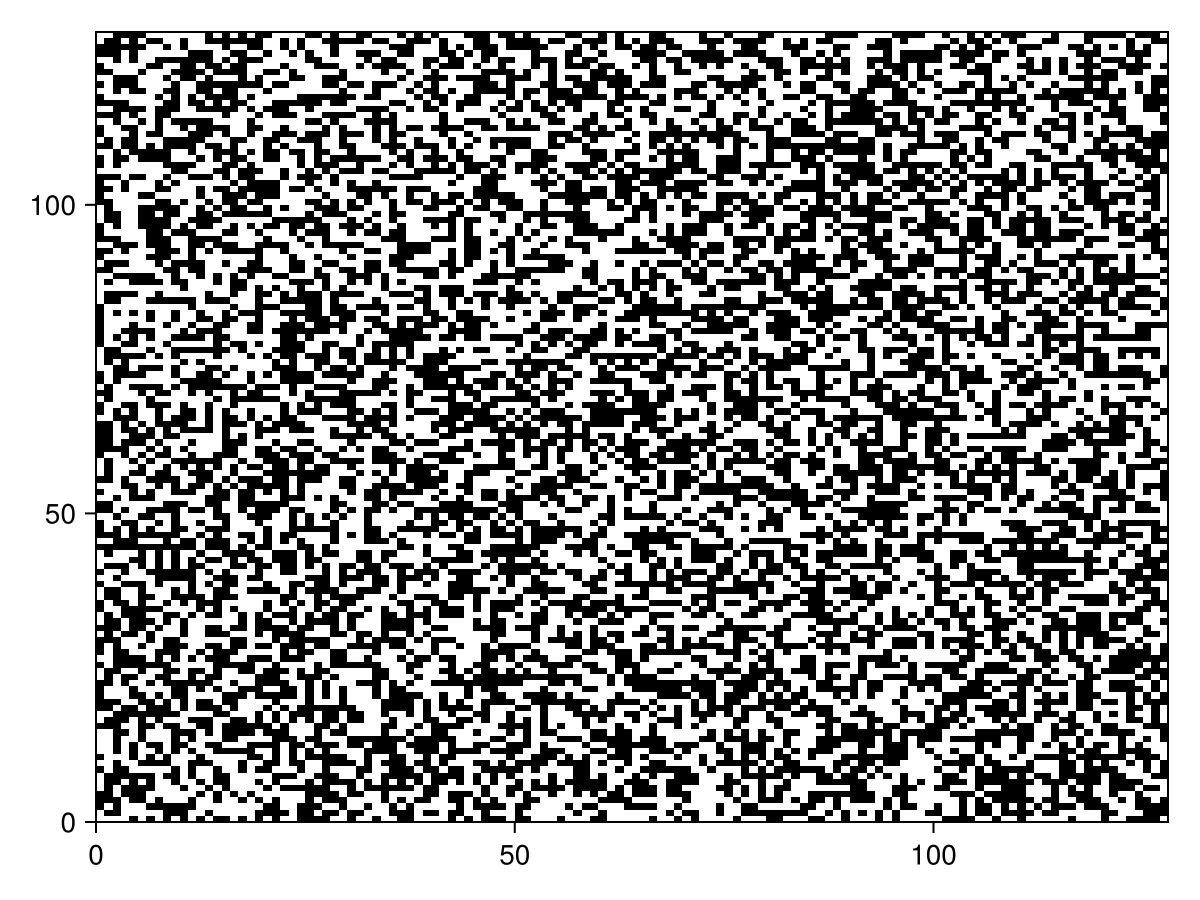

In [3]:
rand_ising2d(m=128, n=m) = rand(Int8[-1, 1], m, n)
image(rand_ising2d(),interpolate=false,aspectratio=:equal)

Our model will have a ferromagnetic interaction between neighboring spins, of stength $J$, and a magnetic field of strength $h$.  Thus if I let $\sigma_{i,j}=\pm1$ be the direction of the spin at location $(i,j)$, the energy of a configuration will be
\begin{equation}
H=\sum_{ij} -J \left[\sigma_{i,j}\sigma_{i+1,j}+\sigma_{i,j}\sigma_{i,j+1}\right]-h\sigma_{i,j}
\end{equation}

We will mostly think about the case $h=0$.

Lets use units where $J=1$, and periodic boundary conditions.  It also makes sense to look at the energy density, rather than the energy itself.  That way we can easily compare systems of different size:

In [4]:
function Energy(s #=spin configuration=#,h)
    m, n = size(s)
    E=0.
    @inbounds for i in 1:m
        @inbounds for j in 1:n
            E+=-s[i,j]*(h+s[mod1(i+1,m),j]+s[i,mod1(j+1,n)])
        end
    end
    return E/(m*n)
end

Energy (generic function with 1 method)

To deal with periodic boundary conditions, we use the mudulus function `mod1(x,b)`: It gives the remainder when $x$ is divided by $b$:

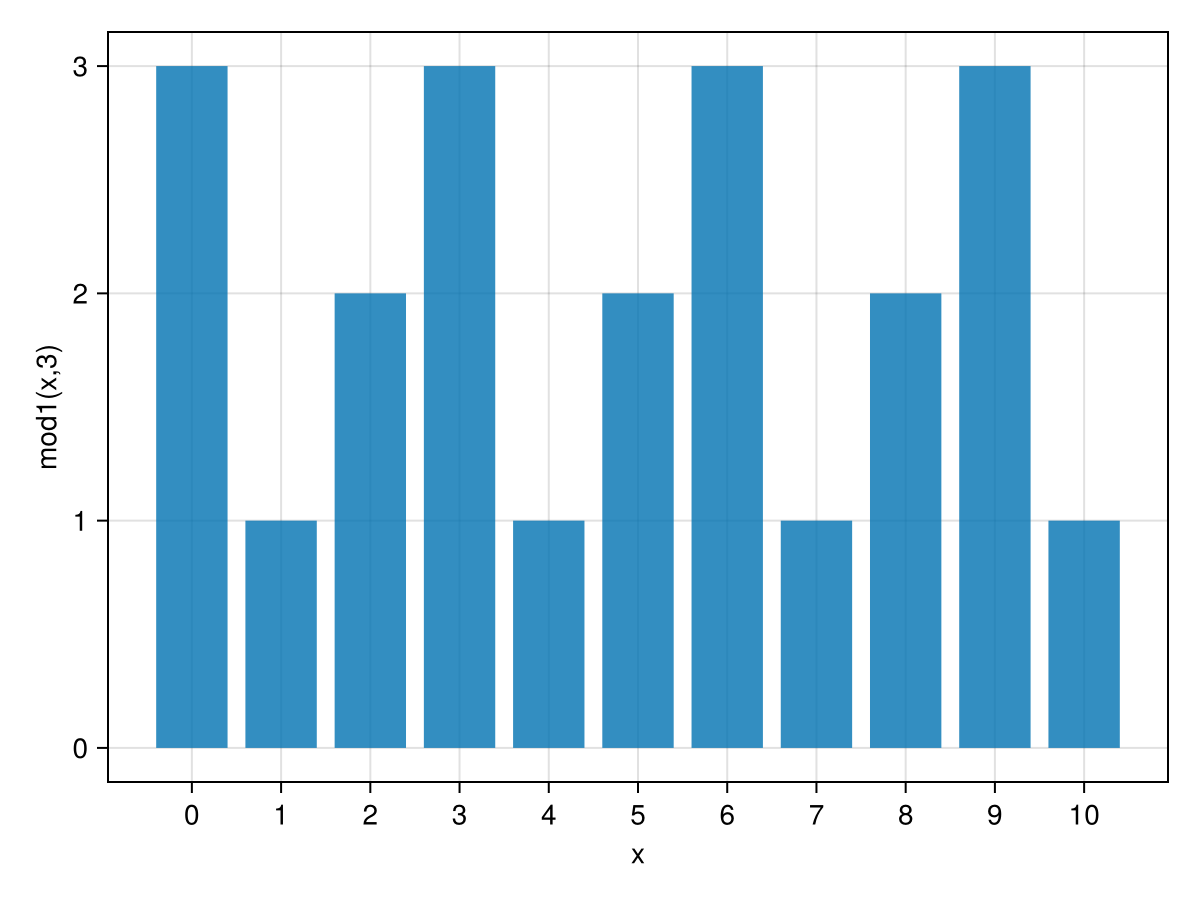

In [5]:
xvals=collect(0:10)
yvals=[mod1(x,3) for x in xvals]
ax = Axis(Figure()[1,1])
ax.xticks=xvals
ax.xlabel="x"
ax.ylabel="mod1(x,3)"
barplot!(ax,xvals,yvals)
current_figure()

The macro `@inbounds` is probably unneccessary.  It turns off certain bounds checking.  This (slighly) speeds up the loop, at the cost of no longer receiving error messages about trying to access/change elements of an array that are outside of bounds.  This can lead to bad bugs.  A good strategy is to first rigorously debug without the `@inbounds` macro, then add it later.

  0.006176 seconds (11.53 k allocations: 800.969 KiB, 98.50% compilation time)
e1 = -0.00347900390625


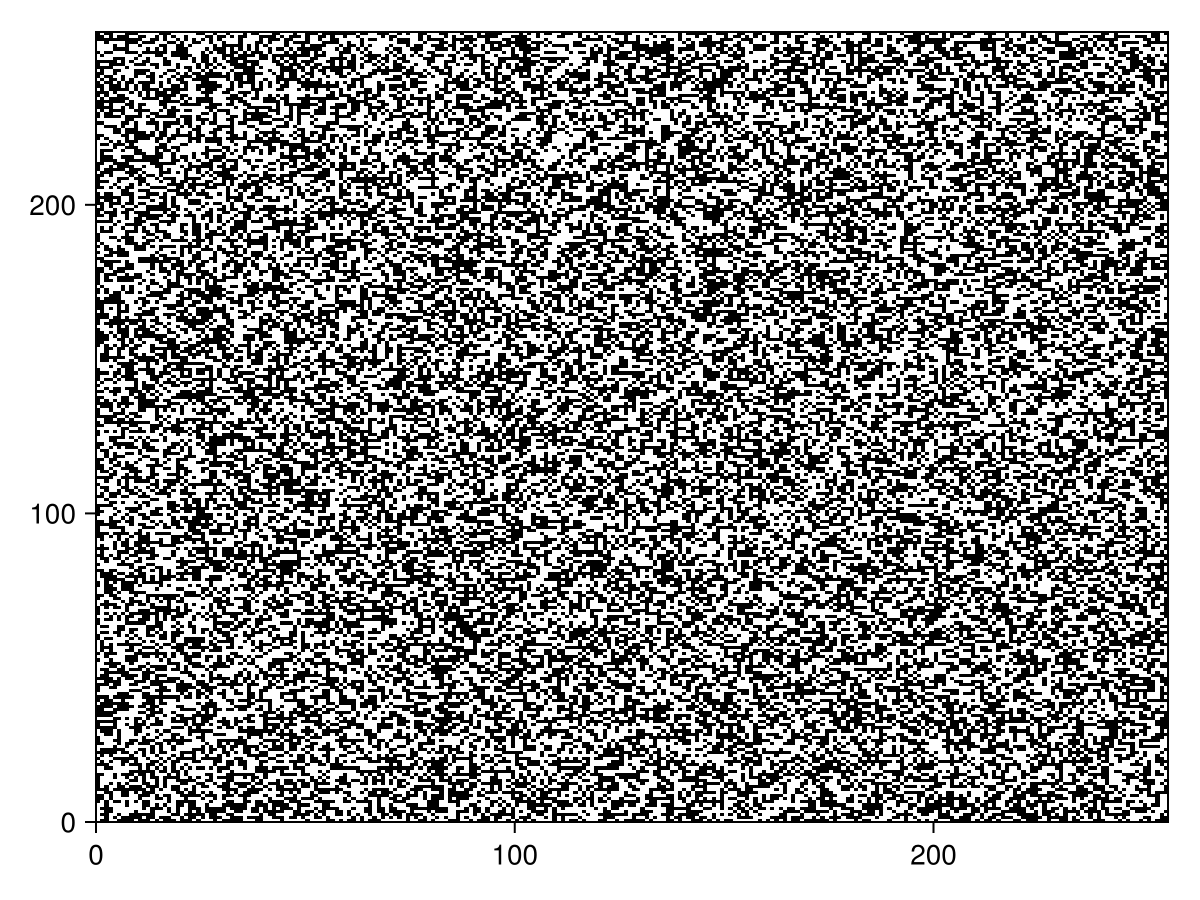

In [6]:
# Here is a random configuration
r1=rand_ising2d(2^8,2^8)
@time e1=Energy(r1,0)
@show e1
image(r1,interpolate=false,aspectratio=:equal)

  0.000080 seconds (1 allocation: 16 bytes)
e2 = -2.0


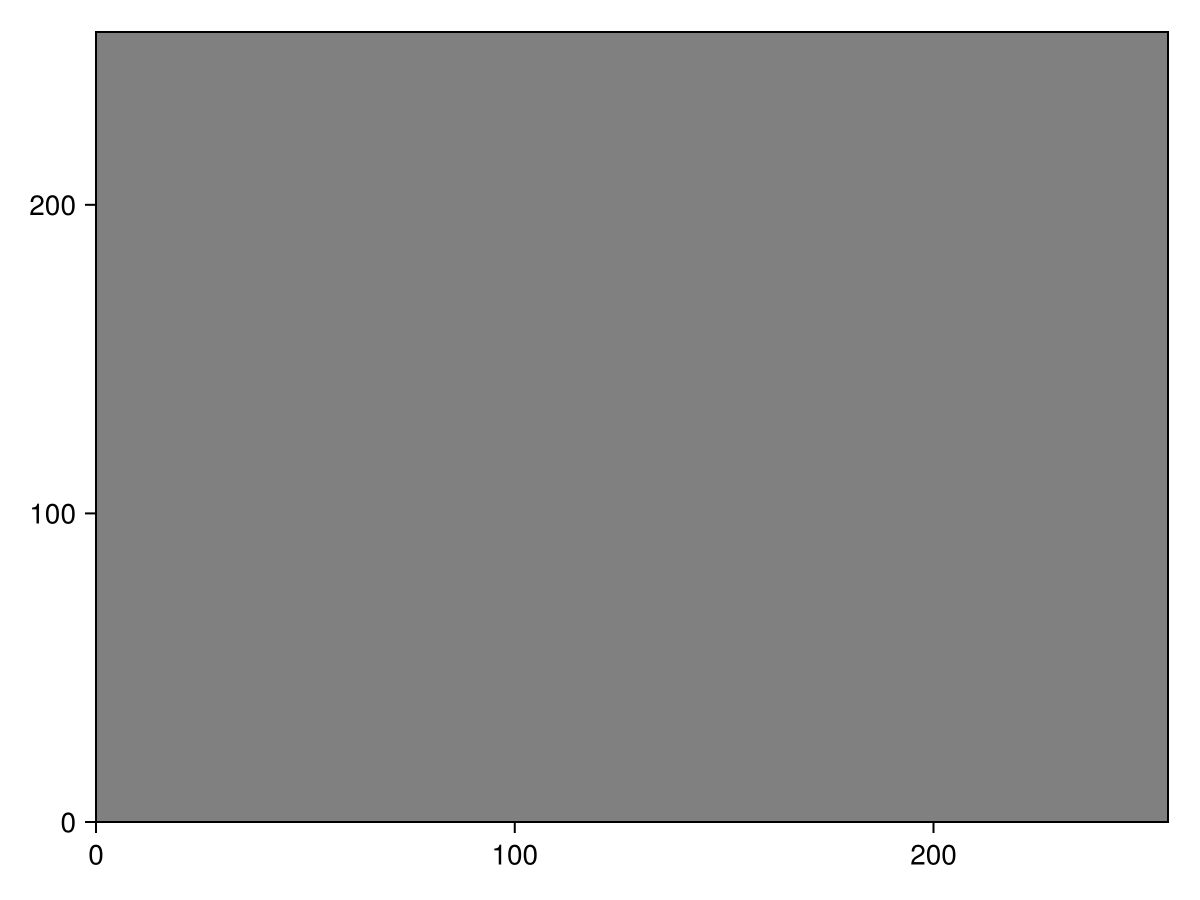

In [7]:
# here is a low energy configuration -- where all of the spins align
fill!(r1,1)
@time e2=Energy(r1,0)
@show e2
image(r1,interpolate=false,aspectratio=:equal)

The physics we will see is that at low temperature the spins tend to point in the same direction, while at high temperatures the spins tend to be random.  It turns out that there is a *phase transition* here, which is analogous to what happens in a magnetic material.

If you heat a magnet to a high enough temperature it stops being a magnet.  This is because the spins/currents which create the magnetic fields will point in random directions, canceling eachother outs.

## Phase Transitions

What is a phase transition?

This is one of the things we hope to learn from studying the Ising model.  There are really two, related, ways people like to think about them:

(1) The most general definition is that a phase transition is a non-analytic point in the thermodynamic functions.

For example in a liquid-gas phase transition the density is discontinuous. 

Typically at a phase transition all thermodynamic quantities will show some signature.  It may be dramatic like a discontinuity or a divergence.  It may instead be something subtle like the third derivative of the quantity with respect to temperature has a discontinuity.

(2) Given the abstractness of the first approach, there is a more concrete picture -- namely that for many phase transitions you can define an *order parameter*.  This is a quantity which vanishes in one phase, and is non-zero in the other.  In our case the magnetization will be an order parameter:
\begin{equation}
m=\frac{1}{N}\sum_{ij} \sigma_{i,j}
\end{equation}

At high temperature a typical configuration will have $m\sim 0$, while at very low temperature $|m|\sim 1$.  Thus we will distinguish the phases by $\langle |m|\rangle$.

Once we have some data it will be more concrete, and we can understand this, and some subtleties which may not be fully apparent on first glance.

In [8]:
Magnetization(s#=spin configuration=#)=mean(s)

Magnetization (generic function with 1 method)

In [9]:
@time Magnetization(r1)

  0.031964 seconds (54.33 k allocations: 3.685 MiB, 99.84% compilation time)


1.0

## Optimizing our energy function

You may note that at every step along the way I have been timing all my operations.  That is because in order to sample the thermodynamic functions, we will need to generate a lot of spin configuration.  Doing it quickly is therefore important. 

Lets look at our energy function:

In [10]:
function Energy(s #=spin configuration=#,h)
    m, n = size(s)
    E=0.
    @inbounds for i in 1:m, j in 1:n
        E+=-s[i,j]*(h+s[mod1(i+1,m),j]+s[i,mod1(j+1,n)])
    end
    return E/(m*n)
end

Energy (generic function with 1 method)

It is a very short function -- which usually indicates that it should be fast.  There is not a lot of things which could slow us down.

One noteworthy feature however, is that at every step of the loop we are evaluateing those `mod1` functions.  These turn out to be a non-trivial contribution to the time of calculating the energy.

We can get rid of them at the cost of making the code much harder to read

In [11]:
function AltEnergy(s #=spin configuration=#,h)
    m, n = size(s)
    # corner
    E=-s[m,n]*(h+s[1,n]+s[m,1])
    # edges
    @inbounds for i in 1:m-1
        E+=-s[i,n]*(h+s[i+1,n]+s[i,1])
    end
    @inbounds for j in 1:n-1
        E+=-s[m,j]*(h+s[1,j]+s[m,j+1])
    end
    # center
    @inbounds for i in 1:m-1
        @inbounds for j in 1:n-1
            E+=-s[i,j]*(h+s[i+1,j]+s[i,j+1])
        end
    end
    return E/(m*n)
end

AltEnergy (generic function with 1 method)

In [12]:
r1=rand_ising2d(2^9)
@time e1=Energy(r1,0)
@time e2=AltEnergy(r1,0)
e1==e2

  0.006164 seconds (7.86 k allocations: 552.969 KiB, 94.18% compilation time)
  0.034054 seconds (14.19 k allocations: 943.438 KiB, 99.26% compilation time)


true

I have warned before about premature optimization.  Here is its ugly cousin -- obfuscating optimization.  If you really need the speed, then the optimized code is certainly the way to go.  What I always do, however, is also write the more straightforward expression, and make sure they agree. 

You also have to make sure that the thing you are optimizing is the rate limiting step.  Here calculating the energy will not be the thing which limits us.  Doubling its speed will have negligable affect on our timings, and it is preferable to use the less-than-optimal, but easily read, `Energy` function.  Generally a factor of 2 is the smallest time-gain that will make me go to ugly code.

## Metropolis algorithm with local updates

Given our Ising model, we now want to sample spin configurations with probabilities
\begin{equation}
P_\sigma \propto e^{-\beta E_\sigma}.
\end{equation}
We have too many states here to simply loop over them:  if we have $N$ spins, there are $2^N$ configurations.  This gets really really big, really really fast.

We also do not know how to draw directly from this distribution.  Thus our strategy will be to construct a Markov chain which has a steady state distribution given by our desired probabilities.

**Recall:**  A Markov chain is a set of rules that randomly moves us between states.  It will generate the desired probability distribution if:

(1) **The move-set is ergodic:**  We can reach any state from any other state in a finite number of moves.

(2) **The moves obey detailed ballance:**  If we have a move from $i$ to $f$, then the transition rates sattisfy
\begin{equation}
p_i \Gamma_{i\to f} =p_f \Gamma_{f\to i}.
\end{equation}

One way to choose $\Gamma$'s which sattisfy detailed ballance is to take
\begin{equation}
\Gamma_{i\to f}=\rm{min}\left(\frac{p_f}{p_i},1\right).
\end{equation}
This choice of $\Gamma$ is known as the Metropolis rules.  In practice we do not need to worry about the `min`.  What we do is we calculate $p_f/p_i$.  We then draw a random number $x$ between $0,1$.  If  $x<p_f/p_i$ we make the move.

We will consider the simplest possible move-set:  We will take a single spin, at location $(i,j)$, and consider two moves:  We either flip the spin, or we keep it the same.  

Let $\sigma=\sigma_{i,j}$ be the initial state of our spin.  And let 
$\tau=\sigma_{i-1,j}+\sigma_{i+1,j}+\sigma_{i,j-1}+\sigma{i,j+1}$ be the sum of the spins of the 4 neighbors.  According to the Metropolis rules, the probability of flipping is the minimum of $1$ and
\begin{align}
P_{\rm flip}&=\frac{e^{-\beta E_{\rm flip}}}{e^{-\beta E_{\rm initial}}}\\
&=e^{-\beta (E_{\rm flip}- E_{\rm initial})}
\end{align}
The nice thing is that most of the contributions to the energies cancel, and we have
\begin{equation}
P_{\rm flip}= e^{2\beta (J\tau+h)\sigma}.
\end{equation}
At high temperatures $\beta\to 0$, this probability goes to 1.  We always flip.  This walks us through disordered configurations.  At low temperatures $\beta\to\infty$, we only flip if it lowers are energy.  Thus we walk towards the uniform state, and once we get there we never leave.  It is useful to tablulate these probabilities.  Again we will use units where $J=1$, so the variables are $\beta J$ and $h/J$ -- which for simplicity we will call `β`, and `h`.  This makes the notation more compact, but can be a bit confusing:  If we want to double $J$, that would be equivalent to doubling both $\beta$ and $h$.

In [13]:
"""
    isingprobs(β,h,numneighbors)

returns a 2D array of probabilities, `probflip[σ,τ]` which is the
probability of flipping a spin if site `i` is in state `σ`, and `τ` is the sum of the 
neighbor spins.  Here `sigma` is `1` or `-1` and `τ` goes from `-numneighbors` to `numneighbors`. 

``P_{\\rm flip}(\\sigma,\\tau)= e^{-2 \\beta  \\sigma \\tau -2 \\beta h \\sigma}``
"""
isingprobs(β,h=0,numneighbors=4)=
    OffsetArray([exp(-2*β*(τ+h)*σ) for σ in -1:1, τ in -numneighbors:numneighbors],
    -1:1,-numneighbors:numneighbors)


isingprobs

Here we used a data structure called an `OffsetArray` -- which is just an `Array` where the indexing starts at numbers other than 1.  For example:

In [14]:
o1=OffsetArray(1:10,-2:7)

1:10 with indices -2:7

In [15]:
@show o1[-2]
@show o1[3]

o1[-2] = 1
o1[3] = 6


6

Here is a high temperature set of probabilities

In [16]:
fliphighT=isingprobs(0.01)

3×9 OffsetArray(::Matrix{Float64}, -1:1, -4:4) with eltype Float64 with indices -1:1×-4:4:
 0.923116  0.941765  0.960789  0.980199  1.0  …  1.04081   1.06184   1.08329
 1.0       1.0       1.0       1.0       1.0     1.0       1.0       1.0
 1.08329   1.06184   1.04081   1.0202    1.0     0.960789  0.941765  0.923116

So if $\sigma=1$ and all its neighbors are also up ($\tau=4$), the flip probability would be

In [17]:
fliphighT[1,4]

0.9231163463866358

If all the neighbors are down we get

In [18]:
fliphighT[1,-4]

1.0832870676749586

This is greater than 1 so if we run

    rand()<fliphighT[1,-4]

the answer is always `true`.  IE. This corresponds to a probability 1 of flipping.

We can also look at low temperature

In [19]:
fliplowT=isingprobs(100)

3×9 OffsetArray(::Matrix{Float64}, -1:1, -4:4) with eltype Float64 with indices -1:1×-4:4:
  0.0  2.6504e-261  1.91517e-174  …  5.22147e173   3.77302e260  Inf
  1.0  1.0          1.0              1.0           1.0           1.0
 Inf   3.77302e260  5.22147e173      1.91517e-174  2.6504e-261   0.0

In [20]:
@show fliplowT[1,-4]
@show fliplowT[1,4]

fliplowT[1, -4] = Inf
fliplowT[1, 4] = 0.0


0.0

So at low $T$ one flips only if it lowers the energy.  Thus the pattern converges to a uniform spin pattern.

## Inner Loop

Now we have the ingredients we need for the key *inner loop* of our algorithm, where we propose spin flip moves one-by-one, accepting or rejecting them.  If we have $N$ spins, we expect that the auto-correlation time of the Markov Chain must be at least $N$.  Thus we are going to run the loop $N\times M$ times.  We call $M$ the number of sweeps.  

In [21]:
function randlocalupdate!(s,probflip,numsweeps)
    m, n = size(s)
    @inbounds for sweep in 1:numsweeps*m*n
        # Choose random spin
        i=rand(1:m)
        j=rand(1:n)
        # Find environment
        τ₁=s[mod1(i-1,m),j]
        τ₂=s[mod1(i+1,m),j]
        τ₃=s[i,mod1(j-1,n)]
        τ₄=s[i,mod1(j+1,n)]
        τ=τ₁+τ₂+τ₃+τ₄
        σ=s[i,j]
        # Propose flip
        if rand()<probflip[σ,τ]
            s[i,j]=-σ
        end
    end
    return s
end

struct isingparams
    β ::Float64
    h ::Float64
end

function randlocalupdate!(s,numsweeps,p::isingparams)
    probflip=isingprobs(p.β,p.h)
    randlocalupdate!(s,probflip,numsweeps)
end

randlocalupdate! (generic function with 2 methods)

  0.790003 seconds (39.85 k allocations: 2.602 MiB, 1.59% compilation time)


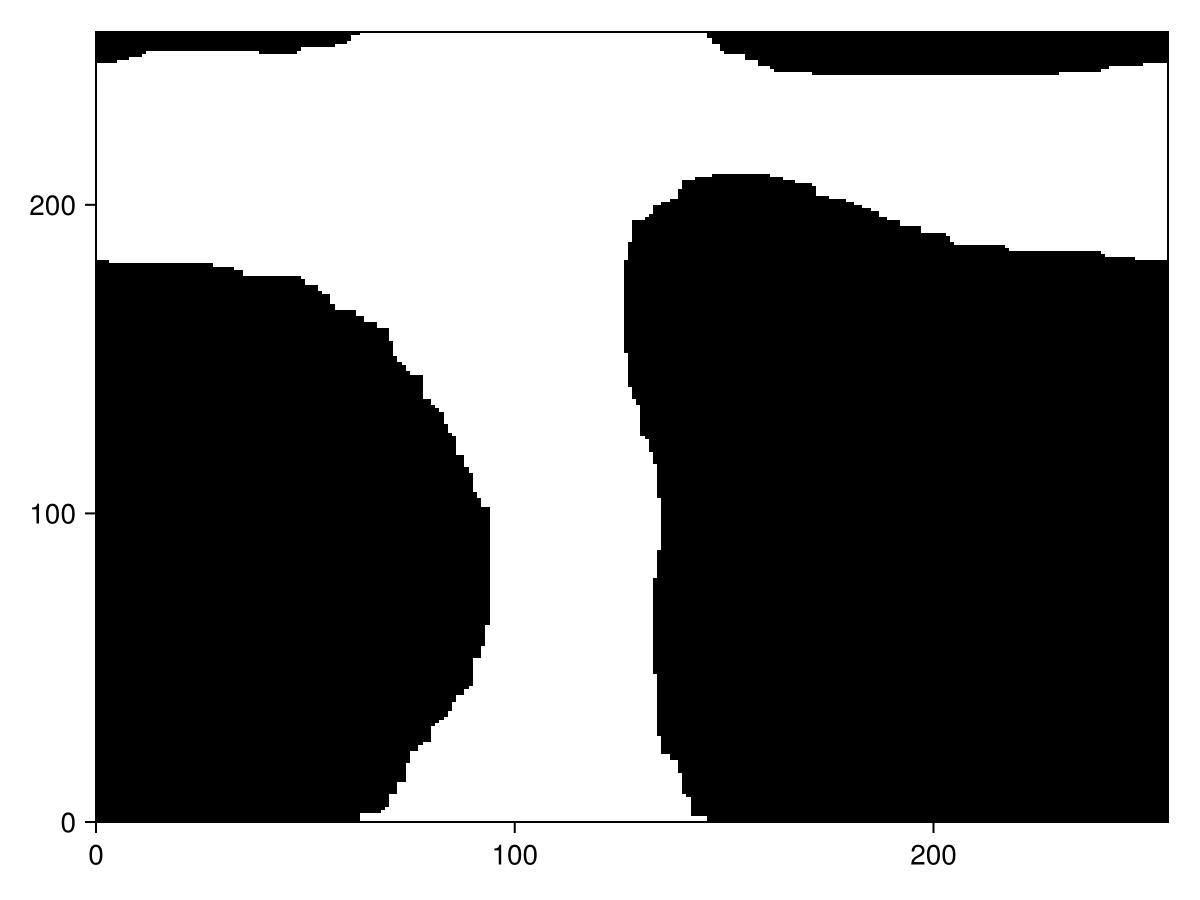

In [22]:
s1=rand_ising2d(2^8)
p1=isingprobs(10.,0.)
@time randlocalupdate!(s1,p1,10^3)
image(s1,interpolate=false,aspectratio=:equal)

  0.954461 seconds


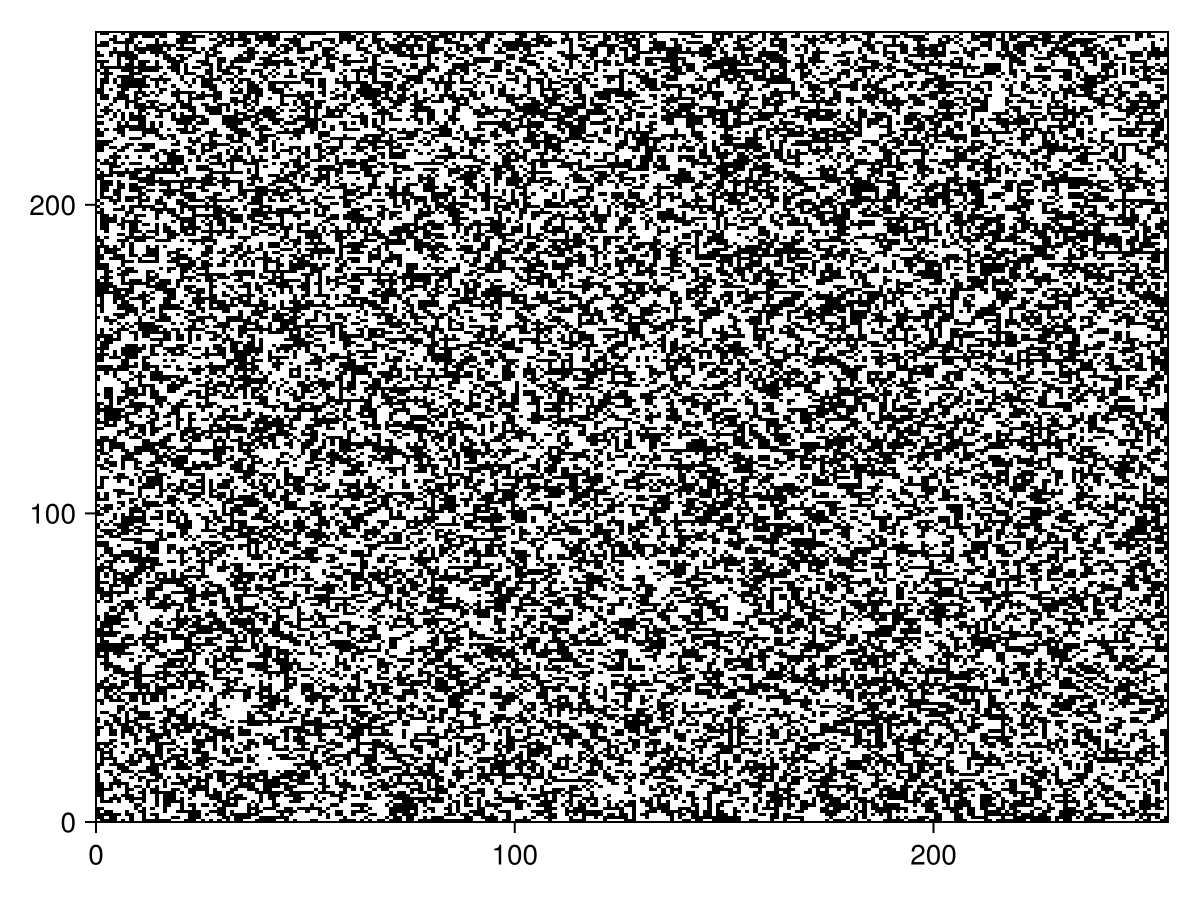

In [23]:
p2=isingprobs(0.1,0.)
@time randlocalupdate!(s1,p2,10^3)
image(s1,interpolate=false,aspectratio=:equal)

## Visualization

Lets now make a quick visualization to see how this works.  Note:  We could surely proceed without the visualization, but it is helpful for getting a quick feel for how the algorithm is working

In [24]:
GLMakie.activate!() #switch from Cairo to GL backend

mutable struct Isingviz
    s
    β
    h
    probflip

# inner constructor
function Isingviz(m=2^8,n=m)
    viz=new()
    # set up GLMakie window
    fig = Figure(); display(fig)
    ax = Axis(fig[1,1])
    ax.title = "Metropolis -- Local update"
    ax.aspect = DataAspect() 
    # Generate Ising Model
    s_obs=Observable(rand_ising2d(m,n))
    s=s_obs[]
    viz.s=s
    #  Display Ising Model
    image!(ax,s_obs,interpolate=false)
    # run button
    isrunning_obs = Observable(false)
    label = map(cond -> cond ? "Stop" : "Run", isrunning_obs)
    run = Button(fig[2,1]; label = label, tellwidth = false)
    on(run.clicks) do clicks; isrunning_obs[] = !isrunning_obs[]; end
    # Make Sliders
    β=0.1
    h=0
    viz.β=β
    viz.h=h
    probflip=isingprobs(β,h)
    viz.probflip=probflip
    sg=SliderGrid(fig[1,2],
        (label="β",range=0.1:0.05:1,format = "{:.2f}",
                startvalue=β),
        (label="h",range=-0.5:0.05:0.5,format = "{:.2f}",startvalue=h),
        (label="log₂(τ)",range=0:1:10,startvalue=3),
        width=400,tellheight=false)
    β_obs=sg.sliders[1].value;
    h_obs=sg.sliders[2].value;
    on(β_obs)  do β_obs
        viz.β=β_obs[]
        probflip.=isingprobs(viz.β,viz.h)
    end
    on(h_obs)  do h_obs
        viz.h=h_obs[]
        probflip.=isingprobs(viz.β,viz.h)
    end
    stepsize_obs=sg.sliders[3].value;
    #
    # Simulation
    #
    Makie.deactivate_interaction!(ax, :rectanglezoom)
    isrunning_notifier = Condition()
    on(cond -> cond && notify(isrunning_notifier), isrunning_obs)
        errormonitor(@async while true
            if isrunning_obs[]
                isopen(fig.scene) || break # stops if window is closed
                randlocalupdate!(s,probflip,2^stepsize_obs[])
                notify(s_obs)
                yield()
            else
                wait(isrunning_notifier)
            end
        end)
    return viz
end

end
    

In [25]:
viz1=Isingviz()

Isingviz(Int8[-1 -1 … -1 -1; 1 -1 … -1 -1; … ; -1 -1 … -1 -1; -1 -1 … -1 1], 0.1, 0, [0.44932896411722156 0.5488116360940264 … 1.822118800390509 2.225540928492468; 1.0 1.0 … 1.0 1.0; 2.225540928492468 1.822118800390509 … 0.5488116360940264 0.44932896411722156])

A couple important things about the simulation:  

(1) We often refer to stepping along the Markov Chain as "time".  By no means should you think about this as representing the dynamics of the spin system.  The Markov Chain is an artificial construct that we are using to try to sample from the equilibrium distribution.  Our goal is to generate independent samples.

(2) We can see very long correlation times.  We will quantify this -- but in the simulation we see structures that persist for long times.  These are bad.  It means we are not generating independent configurations, and we are not getting any new information from averaging over them.

Setting aside these issues, the story is that at low temperatures we mostly see uniform spins, with a few random flips.

  0.788108 seconds


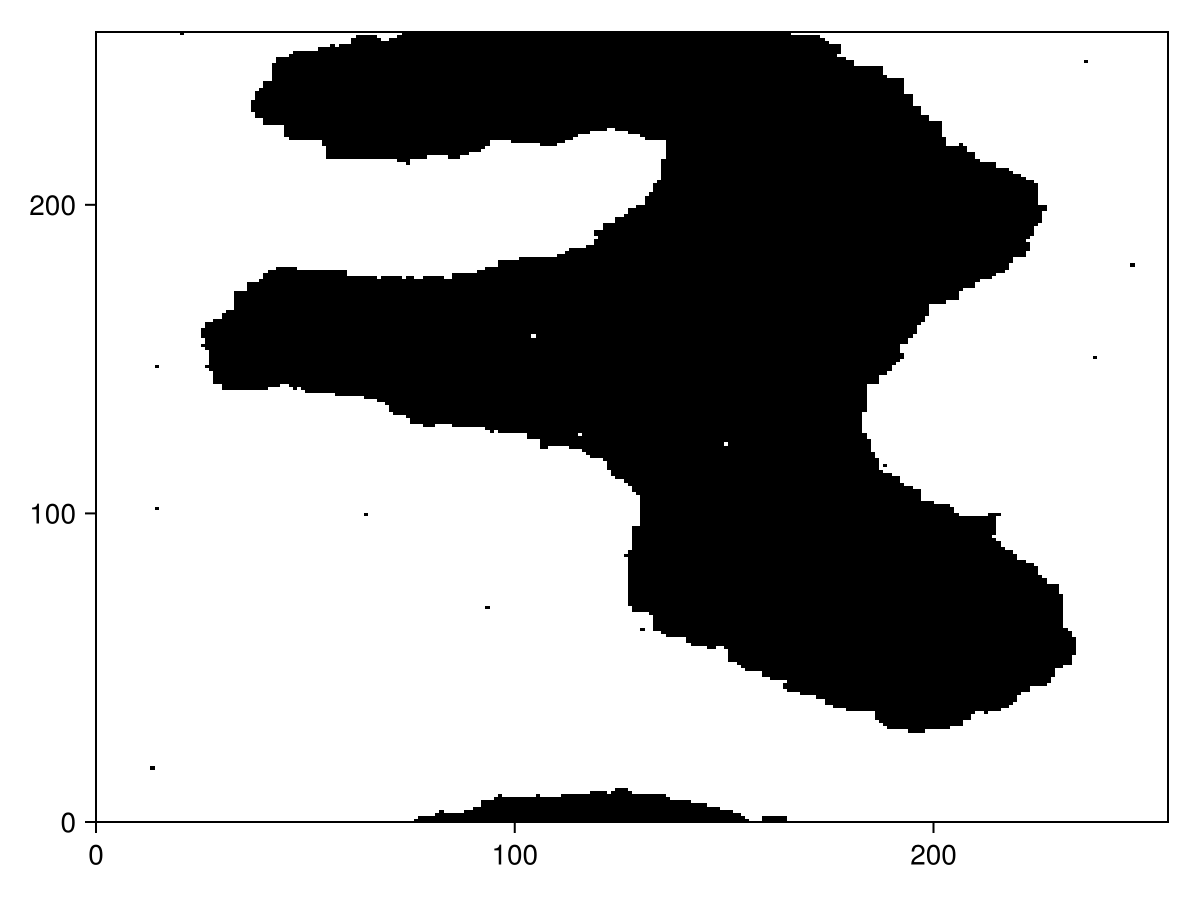

In [30]:
#CairoMakie.activate!(type = "svg")
CairoMakie.activate!(type = "png")
s1=viz1.s
p1=isingprobs(1.,0.)
@time randlocalupdate!(s1,p1,10^3)
image(s1,interpolate=false,aspectratio=:equal)

As we increase the temperature, the size of the flipped clusters, and the number grow:

  0.980981 seconds


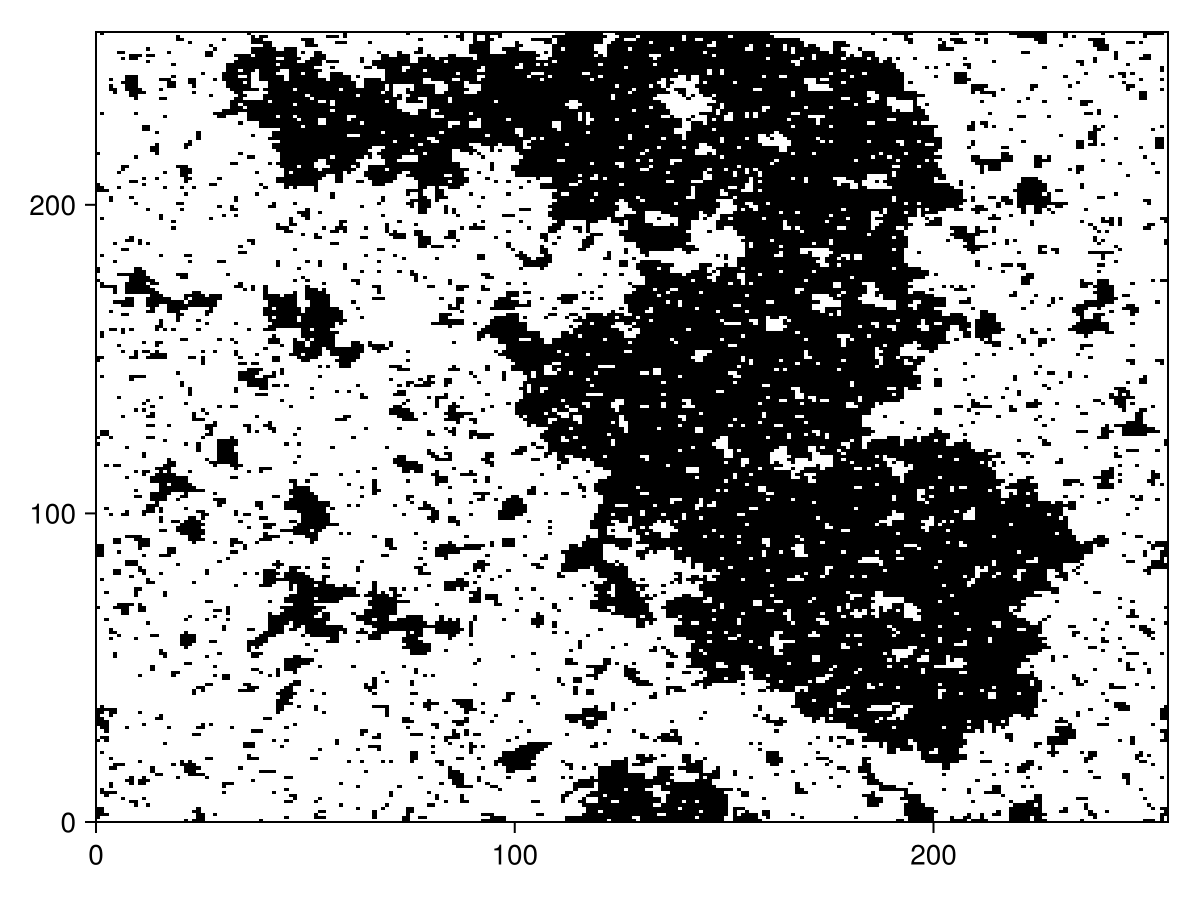

In [31]:
p2=isingprobs(0.45,0.)
@time randlocalupdate!(s1,p2,10^3)
image(s1,interpolate=false,aspectratio=:equal)

The islands get bigger and bigger

 10.087252 seconds


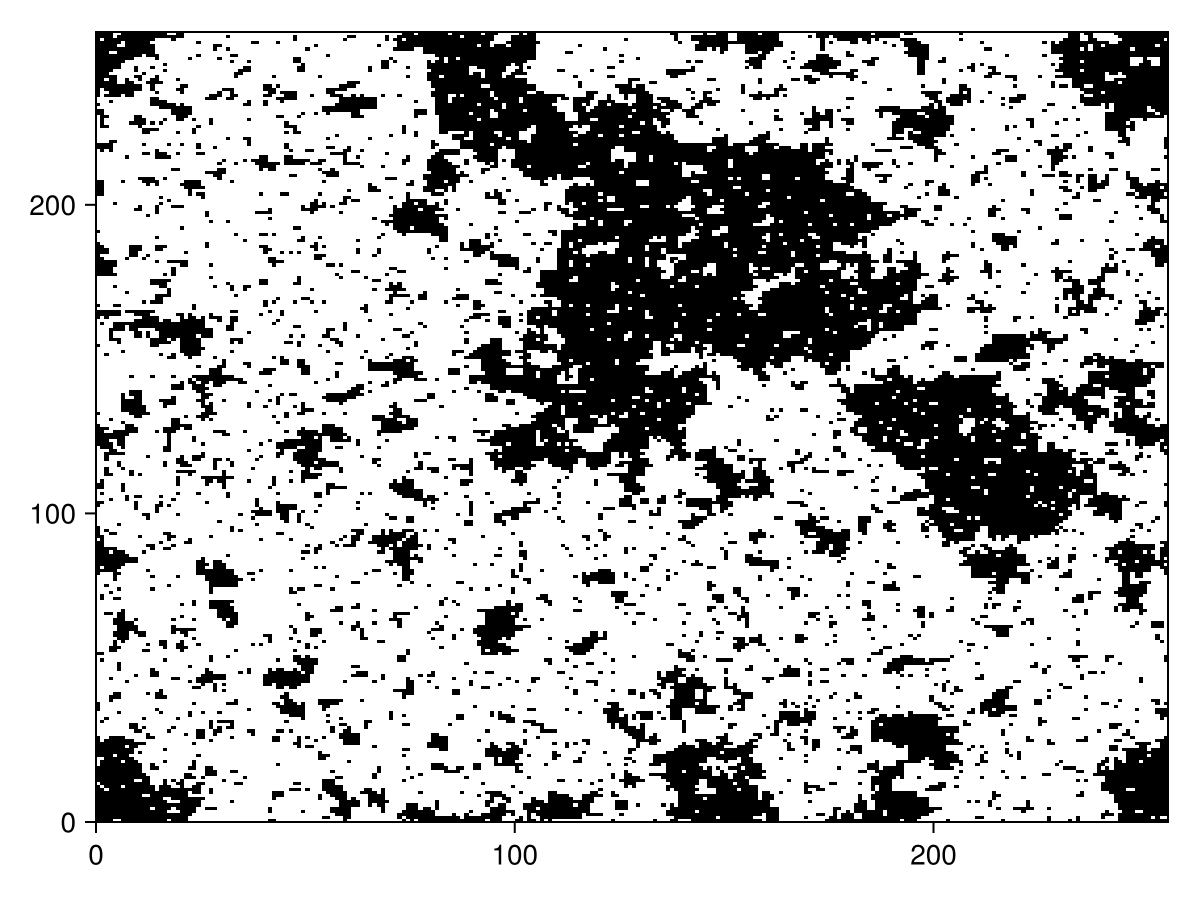

In [32]:
p3=isingprobs(0.44,0.)
@time randlocalupdate!(s1,p3,10^4)
image(s1,interpolate=false,aspectratio=:equal)

At some point there is as much black as white

  1.148264 seconds


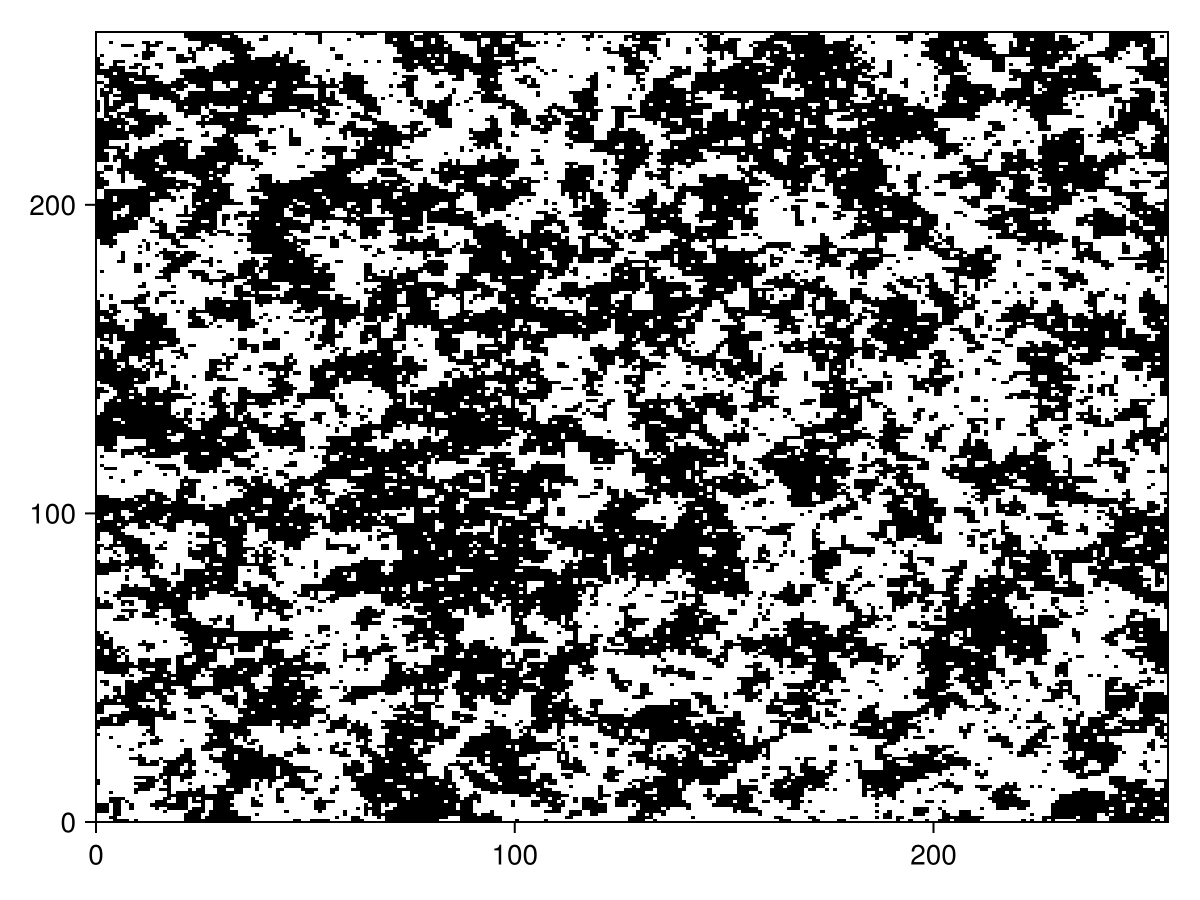

In [33]:
p4=isingprobs(0.4,0.)
@time randlocalupdate!(s1,p4,10^3)
image(s1,interpolate=false,aspectratio=:equal)

This is the disorderd phase.  Note, that the spins are correlated:  There are patches of some characteristic size.  As we go to higher temperature these will shrink, until at very high temperature they are essentially uncorrelated.

Our goal now is to quantify this:  We will look at the behavior of the energy, magnetization, correlation time, and correlation length.  We will also learn how to precisely determine the transition temperature.

It also turns out that this local-update approach leads to a very inefficient way to sample the equilibrium spin distribution.  It works, but we can get orders of magnitude better performance by using a smarter algorithm.  You will code the more sophisticated algorithm.

A good rule is that implementation details are often less important than algorithm choice.